# Imports

In [1]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import warnings
import random

from ucimlrepo import fetch_ucirepo
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV, SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from time import time
from itertools import combinations
from mlxtend.feature_selection import ColumnSelector, SequentialFeatureSelector as mlx_SFS

RANDOM_STATE = 10
N_JOBS = -1
ALL_FEATURES_STR = "All_features"
# Set random seed for numpy
np.random.seed(RANDOM_STATE)
# Set random seed for random module
random.seed(RANDOM_STATE)

## Real data
### Breast Cancer Wisconsin (Diagnostic) Dataset
Benign/malign binary classification task

In [2]:
cancer_df = pd.DataFrame(fetch_ucirepo(id=17).data.features)
cancer_df['class'] = fetch_ucirepo(id=17).data.targets
cancer_df

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,M
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,M
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,M
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,M


#### Description statistics

In [3]:
cancer_df.describe()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [4]:
cancer_df.describe(include='object')

,class
count,569
unique,2
top,B
freq,357


#### Missing values check

In [5]:
missing_values = cancer_df.isnull().any()
print(f"Is there missing values in dry_bean_df:\n{missing_values}")

Is there missing values in dry_bean_df:
radius1               False
texture1              False
perimeter1            False
area1                 False
smoothness1           False
compactness1          False
concavity1            False
concave_points1       False
symmetry1             False
fractal_dimension1    False
radius2               False
texture2              False
perimeter2            False
area2                 False
smoothness2           False
compactness2          False
concavity2            False
concave_points2       False
symmetry2             False
fractal_dimension2    False
radius3               False
texture3              False
perimeter3            False
area3                 False
smoothness3           False
compactness3          False
concavity3            False
concave_points3       False
symmetry3             False
fractal_dimension3    False
class                 False
dtype: bool


#### Target variable distribution

In [6]:
cancer_df['class'].value_counts()

class
B    357
M    212
Name: count, dtype: int64

In [7]:
label_encoder = LabelEncoder()
cancer_df['class'] = label_encoder.fit_transform(cancer_df['class']) # encoding the target variable
scaler = StandardScaler()
features = cancer_df.columns.drop('class')
cancer_df[features] = scaler.fit_transform(cancer_df[features]) # scaling the features
X, y = cancer_df[features].values, cancer_df['class'].values
imp_features_dict = {ALL_FEATURES_STR + f" (k={X.shape[1]})": [np.arange(X.shape[1]), 0]}

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y) # stratified train/test split

#### Univariate feature selection

In [8]:
def performSelectKBest(X_train, y_train):
    """
    Perform feature selection using SelectKBest algorithm.

    Args:
        X_train (array-like): The input training data.
        y_train (array-like): The target training data.

    Returns:
        tuple: A tuple containing the following elements:
            - selector: The SelectKBest object used for feature selection.
            - scores (array-like): The univariate scores for each feature.
            - tic (float): The start time of the feature selection process.
            - toc (float): The end time of the feature selection process.
    """
    selector = SelectKBest(f_classif, k=5)
    tic = time()
    selector.fit(X_train, y_train)
    toc = time()
    X_indices = np.arange(X_train.shape[-1])
    scores = -np.log10(selector.pvalues_)
    scores /= scores.max()

    plt.figure(1)
    plt.clf()
    plt.bar(X_indices - 0.05, scores, width=0.2)
    plt.title("Feature univariate score")
    plt.xlabel("Feature number")
    plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
    plt.show()
    
    return selector, scores, tic, toc

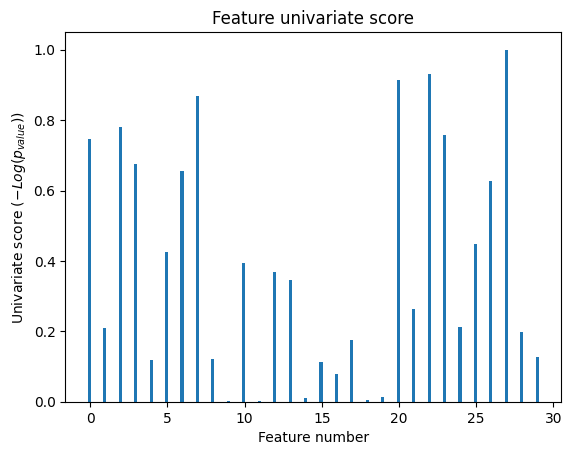

In [9]:
selector, scores, tic, toc = performSelectKBest(X_train, y_train)

In [10]:
selected_features = selector.get_support(indices=True) # get the selected feature indices
for idx in selected_features: # print the selected features and their scores
    print(f"Selected feature: {features[idx]}, score: {scores[idx]:.2f}, feature index: {idx}")

delta = toc - tic # calculate the time taken for feature selection
print(f"Done in {delta:.3f}s")

imp_features_dict.update({"SelectKBest (k=5)": [selected_features, delta]}) # store the selected features and time taken

Selected feature: perimeter1, score: 0.78, feature index: 2
Selected feature: concave_points1, score: 0.87, feature index: 7
Selected feature: radius3, score: 0.91, feature index: 20
Selected feature: perimeter3, score: 0.93, feature index: 22
Selected feature: concave_points3, score: 1.00, feature index: 27
Done in 0.000s


In [11]:
def find_and_print_features(selector, X_train, y_train, imp_features_dict, features,
                            algorithm_name, optimal_feat_quant_func,
                            select_features_func=None):
    """
    Finds and prints the selected features using the given selector.

    Args:
        selector: The feature selector object.
        X_train: The training data features.
        y_train: The training data labels.
        imp_features_dict: A dictionary to store the important features.
        features: A list of feature names.
        algorithm_name: The name of the feature selection algorithm.
        optimal_feat_quant_func: A function to calculate the optimal feature quantity.
        select_features_func: (optional) A function to select the features.

    Returns:
        None
    """

    tic = time()
    selector.fit(X_train, y_train)
    toc = time()

    # Calculate the optimal feature quantity
    feature_num = optimal_feat_quant_func(selector)
    print(f"Optimal feature quantity: {feature_num}")

    if not select_features_func:
        # If select_features_func is not provided, use get_support to get the selected features
        selected_features = selector.get_support(indices=True)
    else:
        # Otherwise, use the provided select_features_func
        selected_features = select_features_func(selector)

    # Print the selected features and their indices
    if features is not None:
        for idx in selected_features:
            print(f"Selected feature: {features[idx]}, feature index: {idx}")
    else:
        for idx in selected_features:
            print(f"Selected feature index: {idx}")

    delta = toc - tic
    print(f"Done in {delta:.3f}s")

    # Update the imp_features_dict with the selected features and the execution time
    imp_features_dict.update({f"{algorithm_name} (k={feature_num})": [selected_features, delta]})

#### Recursive feature elimination (RFE)

In [12]:
estimator = GBC(random_state=RANDOM_STATE)
selector = RFE(estimator, n_features_to_select=5, step=1)
find_and_print_features(selector, X_train, y_train, imp_features_dict, features,
                            "RecursiveFeatureElimination", lambda x: 5)# because there are 5 selected features

Optimal feature quantity: 5
Selected feature: concave_points1, feature index: 7
Selected feature: texture3, feature index: 21
Selected feature: perimeter3, feature index: 22
Selected feature: area3, feature index: 23
Selected feature: concave_points3, feature index: 27
Done in 8.321s


#### Recursive feature elimination with Cross Validation (RFECV)

In [13]:
min_features_to_select = 1
rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=N_JOBS,
)

find_and_print_features(rfecv, X_train, y_train, imp_features_dict, features,
                            "RecursiveFeatureElimination with CV", lambda x: x.n_features_)

Optimal feature quantity: 22
Selected feature: radius1, feature index: 0
Selected feature: texture1, feature index: 1
Selected feature: perimeter1, feature index: 2
Selected feature: area1, feature index: 3
Selected feature: smoothness1, feature index: 4
Selected feature: compactness1, feature index: 5
Selected feature: concavity1, feature index: 6
Selected feature: concave_points1, feature index: 7
Selected feature: symmetry1, feature index: 8
Selected feature: perimeter2, feature index: 12
Selected feature: area2, feature index: 13
Selected feature: smoothness2, feature index: 14
Selected feature: compactness2, feature index: 15
Selected feature: concavity2, feature index: 16
Selected feature: fractal_dimension2, feature index: 19
Selected feature: radius3, feature index: 20
Selected feature: texture3, feature index: 21
Selected feature: perimeter3, feature index: 22
Selected feature: area3, feature index: 23
Selected feature: smoothness3, feature index: 24
Selected feature: concavit

In [14]:
def rfecv_plot(rfecv):
    """
    Plots the mean test accuracy of a recursive feature elimination with cross-validation (RFECV) analysis.
    
    Parameters:
    - rfecv: The RFECV object containing the results of the feature selection.
    
    Returns:
    None
    """
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(10, 6))
    plt.xlabel("Feature quantity")
    plt.ylabel("Mean test accuracy")
    x_values = range(min_features_to_select, n_scores + min_features_to_select)
    plt.errorbar(
        x_values,
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.xticks(x_values, fontsize=8) 
    plt.title("Recursive feature elimination with CV")
    plt.grid(True, linestyle='--')
    plt.show()

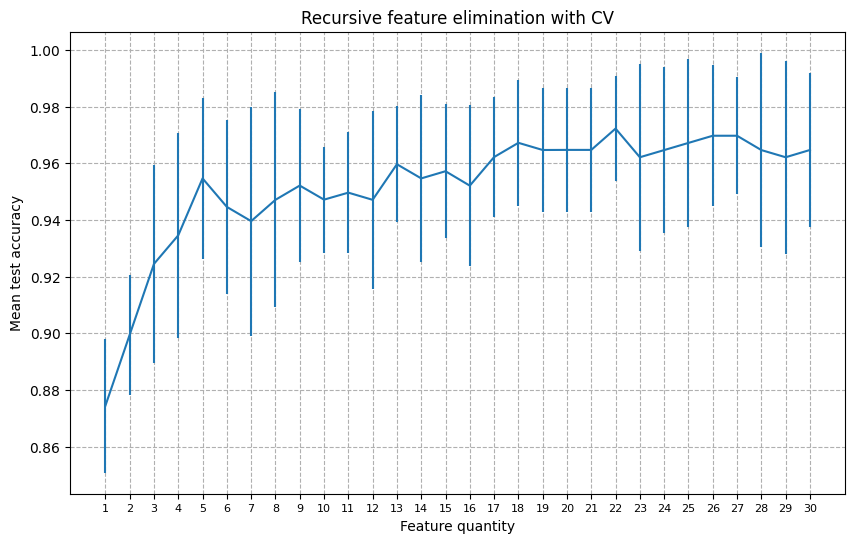

In [15]:
rfecv_plot(rfecv)

#### Sequential Feature Forward Selection

In [16]:
sf_selector = SFS(
    estimator=estimator,
    scoring="accuracy",
    tol=0.001,
    n_jobs=N_JOBS,
) # default 5 fold cross-validation

find_and_print_features(sf_selector, X_train, y_train, imp_features_dict, features,
                            "Forward SFS with CV", lambda x: x.n_features_to_select_)

Optimal feature quantity: 3
Selected feature: symmetry2, feature index: 18
Selected feature: area3, feature index: 23
Selected feature: smoothness3, feature index: 24
Done in 22.517s


#### Sequential Feature Backward Selection

In [17]:
sf_selector = SFS(
    estimator=estimator,
    direction="backward",
    scoring="accuracy",
    n_jobs=N_JOBS
) # default 5 fold cross-validation
# tolerance is not set, since no value provides
# amount of features less than 22

find_and_print_features(sf_selector, X_train, y_train, imp_features_dict, features,
                            "Backward SFS with CV", lambda x: x.n_features_to_select_)

Optimal feature quantity: 15
Selected feature: texture1, feature index: 1
Selected feature: compactness1, feature index: 5
Selected feature: concave_points1, feature index: 7
Selected feature: symmetry1, feature index: 8
Selected feature: perimeter2, feature index: 12
Selected feature: smoothness2, feature index: 14
Selected feature: compactness2, feature index: 15
Selected feature: concavity2, feature index: 16
Selected feature: concave_points2, feature index: 17
Selected feature: fractal_dimension2, feature index: 19
Selected feature: radius3, feature index: 20
Selected feature: texture3, feature index: 21
Selected feature: perimeter3, feature index: 22
Selected feature: area3, feature index: 23
Selected feature: smoothness3, feature index: 24
Done in 167.837s


#### SelectFromModel with L1 Logistic Regression

In [18]:
# Create a Logistic Regression model with L1 regularization
logreg = LogisticRegression(penalty='l1', solver='liblinear')
# Create a SelectFromModel object
selector = SelectFromModel(logreg, threshold=1)

find_and_print_features(selector, X_train, y_train, imp_features_dict, features,
                            "SelectFromModel with L1 LogReg", lambda x: x.transform(X_train).shape[1])

Optimal feature quantity: 5
Selected feature: radius2, feature index: 10
Selected feature: radius3, feature index: 20
Selected feature: texture3, feature index: 21
Selected feature: area3, feature index: 23
Selected feature: concavity3, feature index: 26
Done in 0.003s


#### SelectFromModel with Random Forest Classifier

In [19]:
forest = RFC(n_estimators=500, random_state=RANDOM_STATE)
# Create a SelectFromModel object
selector = SelectFromModel(forest, threshold=0.06)

find_and_print_features(selector, X_train, y_train, imp_features_dict, features,
                            "SelectFromModel with RandomForest", lambda x: x.transform(X_train).shape[1])

Optimal feature quantity: 5
Selected feature: concave_points1, feature index: 7
Selected feature: radius3, feature index: 20
Selected feature: perimeter3, feature index: 22
Selected feature: area3, feature index: 23
Selected feature: concave_points3, feature index: 27
Done in 0.960s


#### Grid Search Cross Validation for feature ranking using ColumnSelector

In [20]:
def column_selector_gs_cv(X_train, y_train, imp_features_dict, features,
                          algorithm_name="ColumnSelector with GridSearchCV",
                          saved_features_quant=5,
                          n_jobs=N_JOBS,
                          num_splits=10):
    """
    Perform feature selection using ColumnSelector with GridSearchCV algorithm.

    Args:
        X_train (array-like): The input training data.
        y_train (array-like): The target training data.
        imp_features_dict (dict): A dictionary to store the important features and algorithm execution time.
        features (list): A list of feature names.
        algorithm_name (str, optional): The name of the algorithm. Defaults to "ColumnSelector with GridSearchCV".
        saved_features_quant (int, optional): The number of features to save. Defaults to 5.
        n_jobs (int, optional): The number of parallel jobs to run. Defaults to N_JOBS.
        num_splits (int, optional): The number of cross-validation splits. Defaults to 10.

    Returns:
        None
    """

    column_combinations = list(combinations(range(X_train.shape[1]), X_train.shape[1]-1))

    pipe = make_pipeline(ColumnSelector(),
                        GBC(random_state=RANDOM_STATE))
    param_grid = {'columnselector__cols': column_combinations}
    grid = GridSearchCV(pipe, param_grid, cv=num_splits, n_jobs=N_JOBS, scoring='accuracy')
    
    tic = time()
    grid.fit(X_train, y_train)
    toc = time()
    # Get the scores from the grid
    
    scores = grid.cv_results_['mean_test_score']

    # Rank the features based on the scores
    rank = np.argsort(scores).argsort() + 1

    # Draw a bar plot for the ranks
    plt.bar(features, rank)
    plt.xlabel('Features')
    plt.ylabel('Rank')
    plt.title(f'Feature Ranks using {algorithm_name} algorithm')
    plt.xticks(rotation=90)
    plt.show()
    
    # Get the indices of the features with the lowest rank
    lowest_rank_indices = np.argsort(rank)[:saved_features_quant]

    # Get the features and their ranks
    lowest_rank_features = [features[i] for i in lowest_rank_indices]
    lowest_rank_values = [rank[i] for i in lowest_rank_indices]

    # Print the features and their ranks
    for feature, rank_value in zip(lowest_rank_features, lowest_rank_values):
        print(f"Feature: {feature}, Rank: {rank_value}")

    delta = toc - tic
    print(f"Done in {delta:.3f}s")

    # Update the imp_features_dict with the selected features and the execution time
    imp_features_dict.update({f"{algorithm_name} (k={saved_features_quant})": [lowest_rank_indices, delta]})

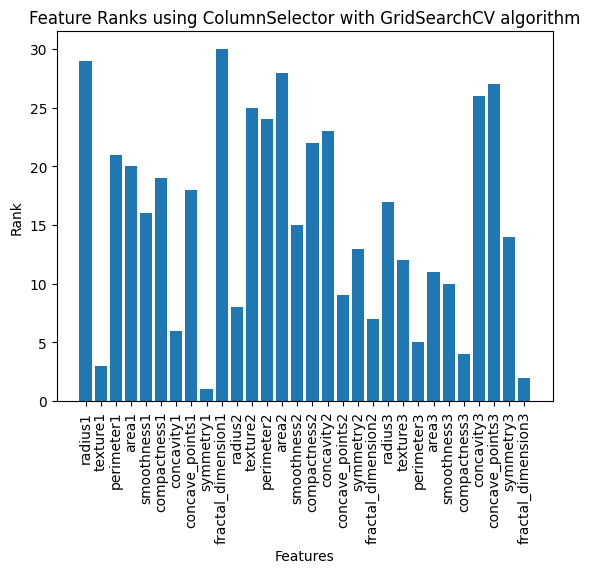

Feature: symmetry1, Rank: 1
Feature: fractal_dimension3, Rank: 2
Feature: texture1, Rank: 3
Feature: compactness3, Rank: 4
Feature: perimeter3, Rank: 5
Done in 30.700s


In [21]:
column_selector_gs_cv(X_train, y_train, imp_features_dict, features)

#### Mlxtend Sequential Feature Forward Selection

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    mlx_sfs = mlx_SFS(
        estimator, 
        k_features="parsimonious", 
        forward=True, 
        floating=False, 
        verbose=2,
        scoring='accuracy',
        cv=5,
        n_jobs=N_JOBS
        )
    
    find_and_print_features(mlx_sfs, X_train, y_train, imp_features_dict, features,
                            "Mlxtend forward SFS with CV",
                            optimal_feat_quant_func=lambda x: len(x.k_feature_idx_),
                            select_features_func=lambda x: x.k_feature_idx_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished

[2024-03-09 13:07:08] Features: 1/30 -- score: 0.8920886075949367[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    4.6s finished

[2024-03-09 13:07:13] Features: 2/30 -- score: 0.9523417721518987[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    4.9s finished

[2024-03-09 13:07:18] Features: 3/30 -- score: 0.9623417721518986[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    4.9s finished

[2024-03-09 13:07:23] Features: 4/30 -- score: 0.9573101265822783[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    5.2s finished



Optimal feature quantity: 21
Selected feature: radius1, feature index: 0
Selected feature: texture1, feature index: 1
Selected feature: perimeter1, feature index: 2
Selected feature: area1, feature index: 3
Selected feature: smoothness1, feature index: 4
Selected feature: compactness1, feature index: 5
Selected feature: concave_points1, feature index: 7
Selected feature: fractal_dimension1, feature index: 9
Selected feature: radius2, feature index: 10
Selected feature: texture2, feature index: 11
Selected feature: perimeter2, feature index: 12
Selected feature: area2, feature index: 13
Selected feature: smoothness2, feature index: 14
Selected feature: concavity2, feature index: 16
Selected feature: symmetry2, feature index: 18
Selected feature: radius3, feature index: 20
Selected feature: texture3, feature index: 21
Selected feature: perimeter3, feature index: 22
Selected feature: area3, feature index: 23
Selected feature: smoothness3, feature index: 24
Selected feature: compactness3, 


[2024-03-09 13:09:14] Features: 30/30 -- score: 0.9647151898734178

In [23]:
def sfs_plot(mlx_sfs):
    """
    Plot the accuracy scores for different numbers of features selected using Sequential Feature Selection.

    Parameters:
    mlx_sfs (object): The SequentialFeatureSelector object containing the results of feature selection.

    Returns:
    None
    """
    metric_dict = mlx_sfs.get_metric_dict()
    k_features = sorted(metric_dict.keys())
    accuracy = [metric_dict[k]['avg_score'] for k in k_features]

    plt.figure(figsize=(10, 6))  # Increase the figure size
    plt.plot(k_features, accuracy)
    plt.xlabel('Number of features')
    plt.ylabel('Accuracy score')
    plt.title('Sequential Feature Selection')
    plt.xticks(k_features, fontsize=8)  # Reduce the font size of xticks
    plt.grid(True, linestyle='--')
    plt.show()

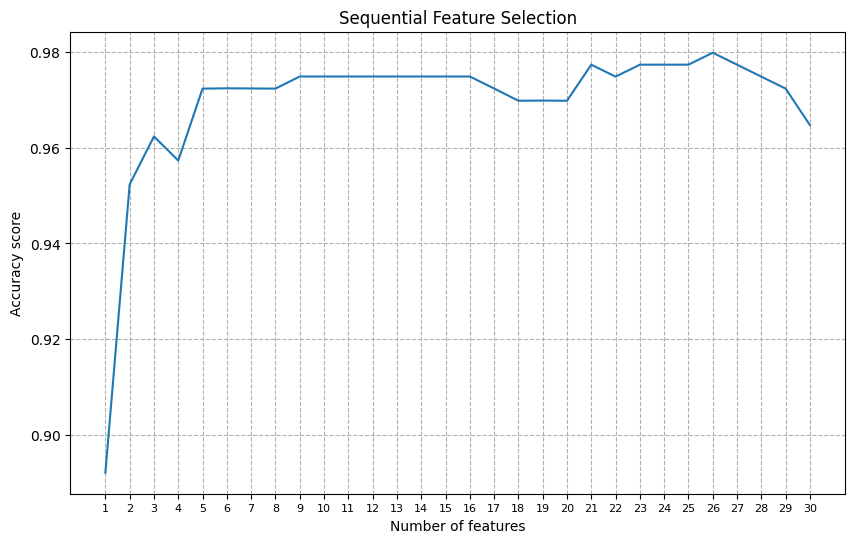

In [24]:
sfs_plot(mlx_sfs)

###

#### Mlxtend Sequential Feature Backward Selection

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    mlx_sfs = mlx_SFS(
        estimator, 
        k_features="parsimonious", 
        forward=False, #backwards selection
        floating=False, 
        verbose=2,
        scoring='accuracy',
        cv=5,
        n_jobs=N_JOBS
        )
    
    find_and_print_features(mlx_sfs, X_train, y_train, imp_features_dict, features,
                            "Mlxtend backward SFS with CV",
                            optimal_feat_quant_func=lambda x: len(x.k_feature_idx_),
                            select_features_func=lambda x: x.k_feature_idx_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.9s finished

[2024-03-09 13:09:30] Features: 29/1 -- score: 0.9723417721518987[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   13.5s finished

[2024-03-09 13:09:43] Features: 28/1 -- score: 0.9748417721518987[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   12.9s finished

[2024-03-09 13:09:56] Features: 27/1 -- score: 0.9773417721518987[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   12.6s finished

[2024-03-09 13:10:09] Features: 26/1 -- score: 0.9823417721518988[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   11.6s finished



Optimal feature quantity: 13
Selected feature: area1, feature index: 3
Selected feature: compactness1, feature index: 5
Selected feature: concavity1, feature index: 6
Selected feature: concave_points1, feature index: 7
Selected feature: area2, feature index: 13
Selected feature: smoothness2, feature index: 14
Selected feature: fractal_dimension2, feature index: 19
Selected feature: radius3, feature index: 20
Selected feature: texture3, feature index: 21
Selected feature: perimeter3, feature index: 22
Selected feature: area3, feature index: 23
Selected feature: smoothness3, feature index: 24
Selected feature: compactness3, feature index: 25
Done in 173.425s


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s finished

[2024-03-09 13:12:07] Features: 1/1 -- score: 0.886993670886076

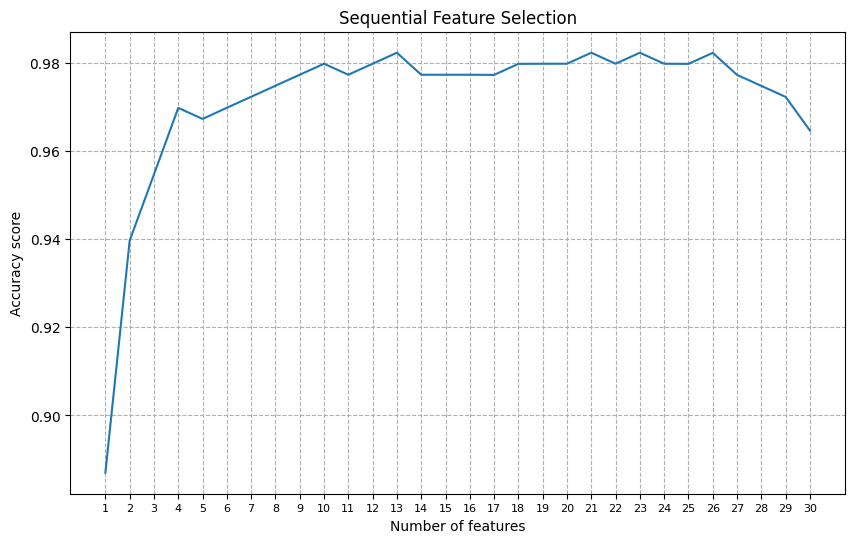

In [26]:
sfs_plot(mlx_sfs)

### Comparing all methods results for Breast Cancer Wisconsin (Diagnostic) Dataset

In [27]:
def plot_method_comparisons(imp_features_dict, X_train, y_train, X_test, y_test,
                            model=lambda: GBC(random_state=RANDOM_STATE)):
    """
    Plots the method comparisons based on the given feature importance dictionary.

    Parameters:
    - imp_features_dict (dict): A dictionary containing the feature importance information for each algorithm.
                               The keys are the algorithm names, and the values are tuples containing the
                               feature indexes and execution times.
    - X_train (array-like): The training data features.
    - y_train (array-like): The training data labels.
    - X_test (array-like): The test data features.
    - y_test (array-like): The test data labels.
    - model (function, optional): The machine learning model to use. Defaults to GBC.

    Returns:
    - feature_selection_methods (numpy.ndarray): An array of  names.
    - accuracies (numpy.ndarray): An array of accuracies corresponding to each algorithm.
    - execution_times (numpy.ndarray): An array of execution times corresponding to each algorithm.
    """

    # Create empty lists to store the accuracy and execution time for each algorithm
    accuracies = []
    execution_times = []

    # Iterate over the imp_features_dict
    for algorithm, (feature_indexes, execution_time) in imp_features_dict.items():
        # Select the columns with appropriate indexes from X_train
        X_train_selected = X_train[:, feature_indexes]
        
        # Select the columns with appropriate indexes from X_test
        X_test_selected = X_test[:, feature_indexes]
        
        # Fit the GBC on the selected data
        gbc = model()
        gbc.fit(X_train_selected, y_train)
        
        # Test the GBC on X_test
        accuracy = gbc.score(X_test_selected, y_test)
        
        # Append the accuracy and execution time to the lists
        accuracies.append(accuracy)
        execution_times.append(execution_time)

    extracted_k = [int(key.split('=')[1].rstrip(')')) for key in imp_features_dict.keys()]
    sorted_by_k_idx = np.argsort(extracted_k)
    # Sort the imp_features_dict by the value of num in ascending order
    # Extract the feature names and execution times from the sorted_dict
    feature_selection_methods = np.array(list(imp_features_dict.keys()))[sorted_by_k_idx]
    accuracies = np.array(accuracies)[sorted_by_k_idx]
    execution_times = np.array(execution_times)[sorted_by_k_idx]

    fig, ax1 = plt.subplots(figsize=(10, 8))

    # Plot the accuracies as a bar plot
    ax1.bar(np.arange(len(feature_selection_methods)), accuracies, color='b')
    ax1.set_ylabel('Accuracy')

    # Create a second y-axis for execution time
    ax2 = ax1.twinx()
    ax2.plot(np.arange(len(feature_selection_methods)), execution_times, color='r', marker='o')
    ax2.set_ylabel('Execution Time (s)')

    # Set the x-axis ticks and labels
    ax1.set_xticks(np.arange(len(feature_selection_methods)))
    ax1.set_xticklabels(feature_selection_methods, rotation=90)

    # Add legend
    ax1.legend(['Accuracy'], loc='upper left')
    ax2.legend(['Execution Time'], loc='upper right')

    # Show the plot
    plt.show()
    
    return feature_selection_methods, accuracies, execution_times

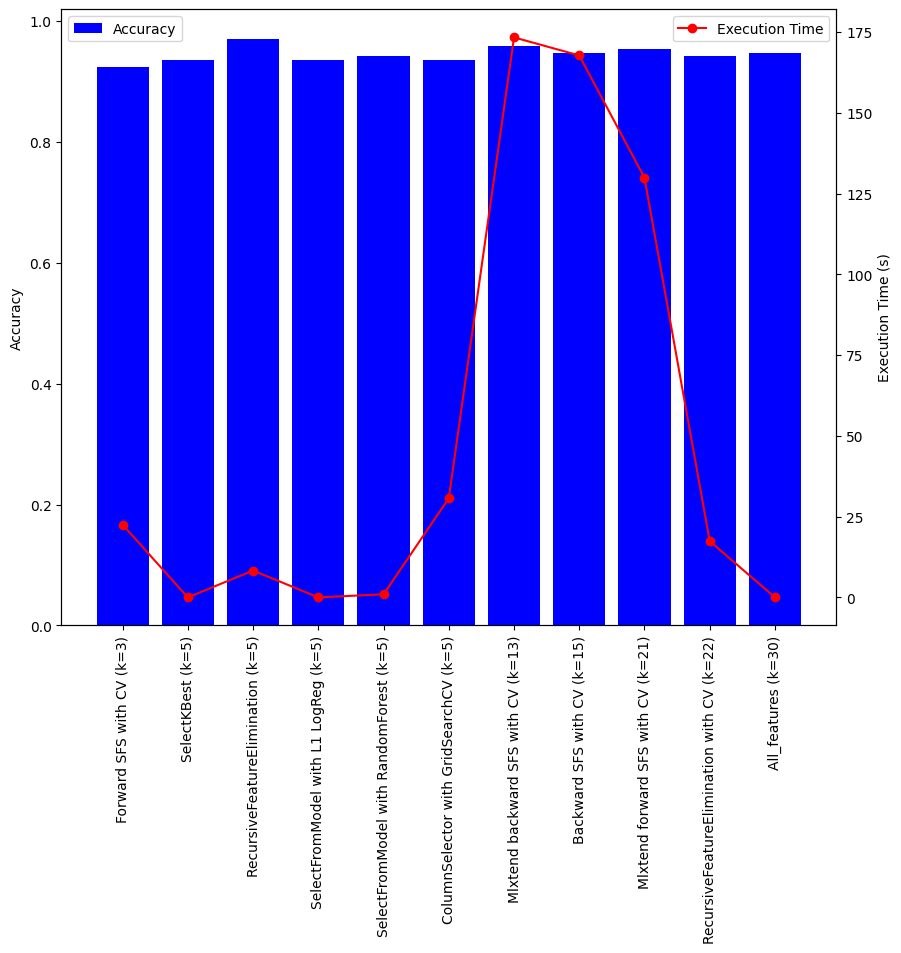

In [28]:
feature_selection_methods, accuracies, execution_times = plot_method_comparisons(imp_features_dict, X_train, y_train, X_test, y_test)

In [29]:
def output_best_candidates(feature_selection_methods, accuracies, execution_times):
    # Find the index of "All_features" in feature_selection_methods
    index = np.where(np.char.startswith(feature_selection_methods, ALL_FEATURES_STR))[0][0]

    # Delete "All_features" from feature_selection_methods, accuracies, and execution_times
    feature_selection_methods = np.delete(feature_selection_methods, index)
    accuracies = np.delete(accuracies, index)
    execution_times = np.delete(execution_times, index)
    
    best_accuracy_method = feature_selection_methods[np.argmax(accuracies)]
    best_time_method = feature_selection_methods[np.argmin(execution_times)]

    best_accuracy_value = np.max(accuracies)
    best_time_value = np.min(execution_times)

    print("Feature selection method with the best accuracy:", best_accuracy_method)
    print("Accuracy value:", best_accuracy_value)

    print("\nFeature selection method with the best time:", best_time_method)
    print("Time value:", best_time_value)

In [30]:
output_best_candidates(feature_selection_methods, accuracies, execution_times)

Feature selection method with the best accuracy: RecursiveFeatureElimination (k=5)
Accuracy value: 0.9707602339181286

Feature selection method with the best time: SelectKBest (k=5)
Time value: 0.0


<font size="5">**Conclusions:**</font> As we can see, using different methods of selecting the most important features, we can get a little bit of accuracy gain in the model. The graph shows that different methods can take much longer to complete than others. The best result was achieved by RecursiveFeatureElimination, which selected the 5 most significant features, and it also takes a short time to run, so we can say that it is the best method for this dataset and Gradient Boost Classifier. We can also see that this method provided better results, than using all of the dataset features.

### Generated data

In [31]:
X_gen, y_gen = make_classification(
    n_samples=500,
    n_features=20,
    n_informative=5,
    n_redundant=3,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    class_sep=0.8,
    random_state=RANDOM_STATE
)

X_gen_insuff, y_gen_insuff = make_classification(
    n_samples=105,
    n_features=110,
    n_informative=5,
    n_redundant=3,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    class_sep=0.8,
    random_state=RANDOM_STATE
)

estimator_gen = LogisticRegression()
# estimator_gen = GBC(random_state=RANDOM_STATE) # takes to long in case of n_features > n_samples, so LogisticRegression is used

In [32]:
imp_features_dict_gen = {ALL_FEATURES_STR + f" (k={X_gen.shape[1]})": [np.arange(X_gen.shape[1]), 0]}
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_gen,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y_gen)

#### Univariate feature selection

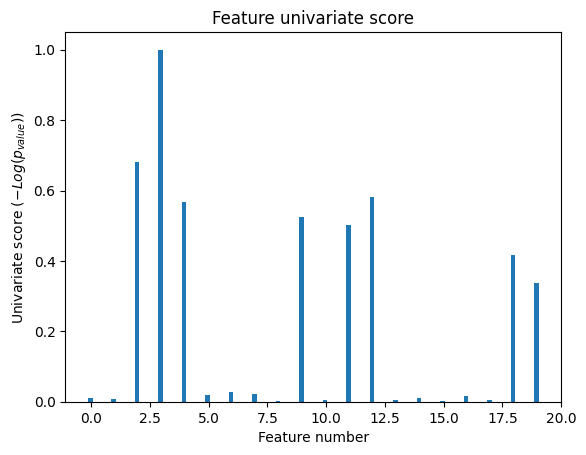

In [33]:
selector, scores, tic, toc = performSelectKBest(X_train, y_train)

In [34]:
selected_features = selector.get_support(indices=True)
for idx in selected_features:
    print(f"Selected feature index: {idx}, score: {scores[idx]:.2f}")

delta = toc - tic
print(f"Done in {delta:.3f}s")

imp_features_dict_gen.update({"SelectKBest (k=5)": [selected_features, delta]})

Selected feature index: 2, score: 0.68
Selected feature index: 3, score: 1.00
Selected feature index: 4, score: 0.57
Selected feature index: 9, score: 0.53
Selected feature index: 12, score: 0.58
Done in 0.003s


#### Recursive feature elimination (RFE)

In [35]:
selector = RFE(estimator_gen, n_features_to_select=5, step=1)
find_and_print_features(selector, X_train, y_train, imp_features_dict_gen, None,
                            "RecursiveFeatureElimination", lambda x: 5)# because there are 5 selected features

Optimal feature quantity: 5
Selected feature index: 2
Selected feature index: 3
Selected feature index: 11
Selected feature index: 12
Selected feature index: 18
Done in 0.148s


#### Recursive feature elimination with Cross Validation (RFECV)

In [36]:
min_features_to_select = 1
rfecv = RFECV(
    estimator=estimator_gen,
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

find_and_print_features(rfecv, X_train, y_train, imp_features_dict_gen, None,
                            "RecursiveFeatureElimination with CV", lambda x: x.n_features_)

Optimal feature quantity: 6
Selected feature index: 2
Selected feature index: 3
Selected feature index: 11
Selected feature index: 12
Selected feature index: 18
Selected feature index: 19
Done in 0.471s


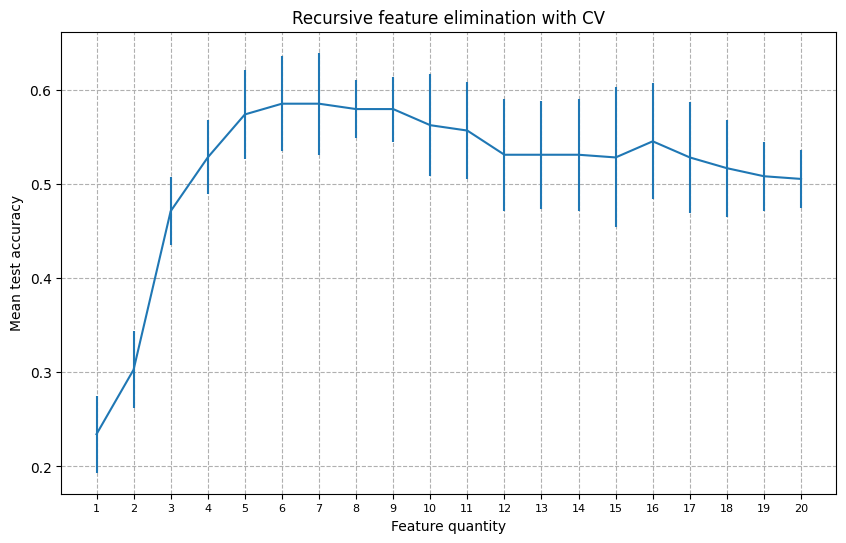

In [37]:
rfecv_plot(rfecv)

#### Sequential Feature Forward Selection

In [38]:
sf_selector = SFS(
    estimator=estimator_gen,
    scoring="accuracy",
    tol=0.01,
    n_jobs=-1,
) # default 5 fold cross-validation

find_and_print_features(sf_selector, X_train, y_train, imp_features_dict_gen, None,
                            "Forward SFS with CV", lambda x: x.n_features_to_select_)

Optimal feature quantity: 5
Selected feature index: 2
Selected feature index: 3
Selected feature index: 12
Selected feature index: 18
Selected feature index: 19
Done in 2.953s


#### Sequential Feature Backward Selection

In [39]:
sf_selector = SFS(
    estimator=estimator_gen,
    direction="backward",
    scoring="accuracy",
    n_jobs=-1,
) # default 5 fold cross-validation
# tolerance is not set, since no value provides
# amount of features less than 13

find_and_print_features(sf_selector, X_train, y_train, imp_features_dict_gen, None,
                            "Backward SFS with CV", lambda x: x.n_features_to_select_)

Optimal feature quantity: 10
Selected feature index: 2
Selected feature index: 3
Selected feature index: 4
Selected feature index: 5
Selected feature index: 6
Selected feature index: 8
Selected feature index: 13
Selected feature index: 14
Selected feature index: 18
Selected feature index: 19
Done in 4.750s


#### SelectFromModel with L1 Logistic Regression

In [40]:
# Create a Logistic Regression model with L1 regularization
logreg = LogisticRegression(penalty='l1', solver='liblinear')
# Create a SelectFromModel object
selector = SelectFromModel(logreg, threshold=1.5)

find_and_print_features(selector, X_train, y_train, imp_features_dict_gen, None,
                            "SelectFromModel with L1 LogReg", lambda x: x.transform(X_train).shape[1])

Optimal feature quantity: 5
Selected feature index: 3
Selected feature index: 5
Selected feature index: 11
Selected feature index: 12
Selected feature index: 18
Done in 0.023s


#### SelectFromModel with Random Forest Classifier

In [41]:
forest = RFC(n_estimators=500, random_state=RANDOM_STATE)
# Create a SelectFromModel object
selector = SelectFromModel(forest, threshold=0.08)

find_and_print_features(selector, X_train, y_train, imp_features_dict_gen, None,
                            "SelectFromModel with RandomForest", lambda x: x.transform(X_train).shape[1])

Optimal feature quantity: 5
Selected feature index: 2
Selected feature index: 3
Selected feature index: 4
Selected feature index: 9
Selected feature index: 12
Done in 1.068s


#### Grid Search Cross Validation for feature ranking using ColumnSelector

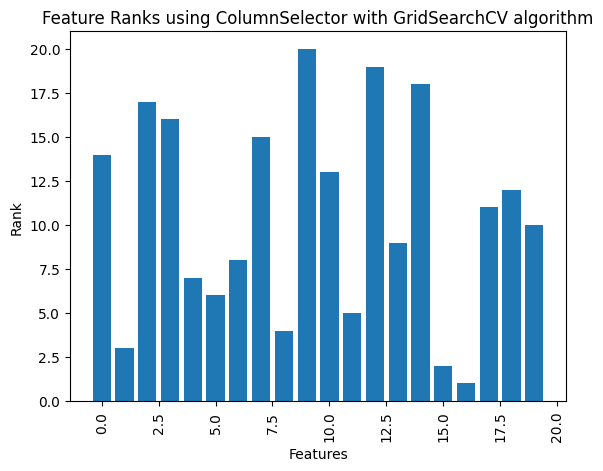

Feature: 16, Rank: 1
Feature: 15, Rank: 2
Feature: 1, Rank: 3
Feature: 8, Rank: 4
Feature: 11, Rank: 5
Done in 106.543s


In [42]:
column_selector_gs_cv(X_train, y_train, imp_features_dict_gen, np.arange(X_train.shape[1]))

#### Mlxtend Sequential Feature Forward Selection

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    mlx_sfs = mlx_SFS(
        estimator_gen, 
        k_features="parsimonious", 
        forward=True, 
        floating=False, 
        verbose=2,
        scoring='accuracy',
        cv=5,
        n_jobs=-1
        )
    
    find_and_print_features(mlx_sfs, X_train, y_train, imp_features_dict_gen, None,
                            "Mlxtend forward SFS with CV",
                            optimal_feat_quant_func=lambda x: len(x.k_feature_idx_),
                            select_features_func=lambda x: x.k_feature_idx_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished

[2024-03-09 13:14:08] Features: 1/20 -- score: 0.24571428571428572[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.0s finished

[2024-03-09 13:14:08] Features: 2/20 -- score: 0.3942857142857143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2024-03-09 13:14:08] Features: 3/20 -- score: 0.4885714285714286[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  1

Optimal feature quantity: 5
Selected feature index: 2
Selected feature index: 3
Selected feature index: 12
Selected feature index: 18
Selected feature index: 19
Done in 2.668s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2024-03-09 13:14:10] Features: 18/20 -- score: 0.5257142857142857[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2024-03-09 13:14:10] Features: 19/20 -- score: 0.52[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[2024-03-09 13:14:10] Features: 20/20 -- score: 0.5057142857142857

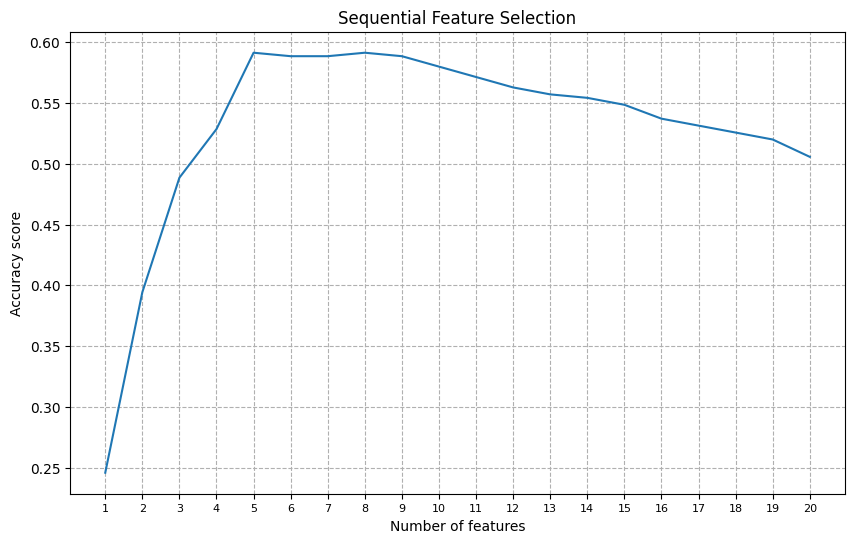

In [44]:
sfs_plot(mlx_sfs)

#### Mlxtend Sequential Feature Backward Selection

In [45]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    mlx_sfs = mlx_SFS(
        estimator_gen, 
        k_features="parsimonious", 
        forward=False, #backwards selection
        floating=False, 
        verbose=2,
        scoring='accuracy',
        cv=5,
        n_jobs=-1
        )
    
    find_and_print_features(mlx_sfs, X_train, y_train, imp_features_dict_gen, None,
                            "Mlxtend backward SFS with CV",
                            optimal_feat_quant_func=lambda x: len(x.k_feature_idx_),
                            select_features_func=lambda x: x.k_feature_idx_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2024-03-09 13:14:11] Features: 19/1 -- score: 0.5257142857142856[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.2s finished

[2024-03-09 13:14:11] Features: 18/1 -- score: 0.5285714285714287[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2024-03-09 13:14:11] Features: 17/1 -- score: 0.5314285714285715[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17

Optimal feature quantity: 5
Selected feature index: 2
Selected feature index: 3
Selected feature index: 4
Selected feature index: 18
Selected feature index: 19
Done in 2.738s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2024-03-09 13:14:13] Features: 2/1 -- score: 0.37142857142857144[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2024-03-09 13:14:13] Features: 1/1 -- score: 0.24571428571428572

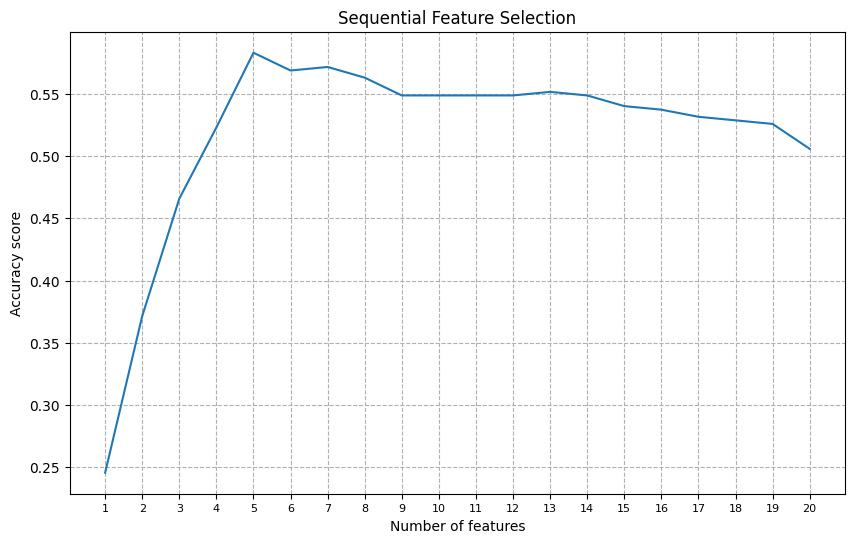

In [46]:
sfs_plot(mlx_sfs)

### Comparing all methods results for the Generated Dataset

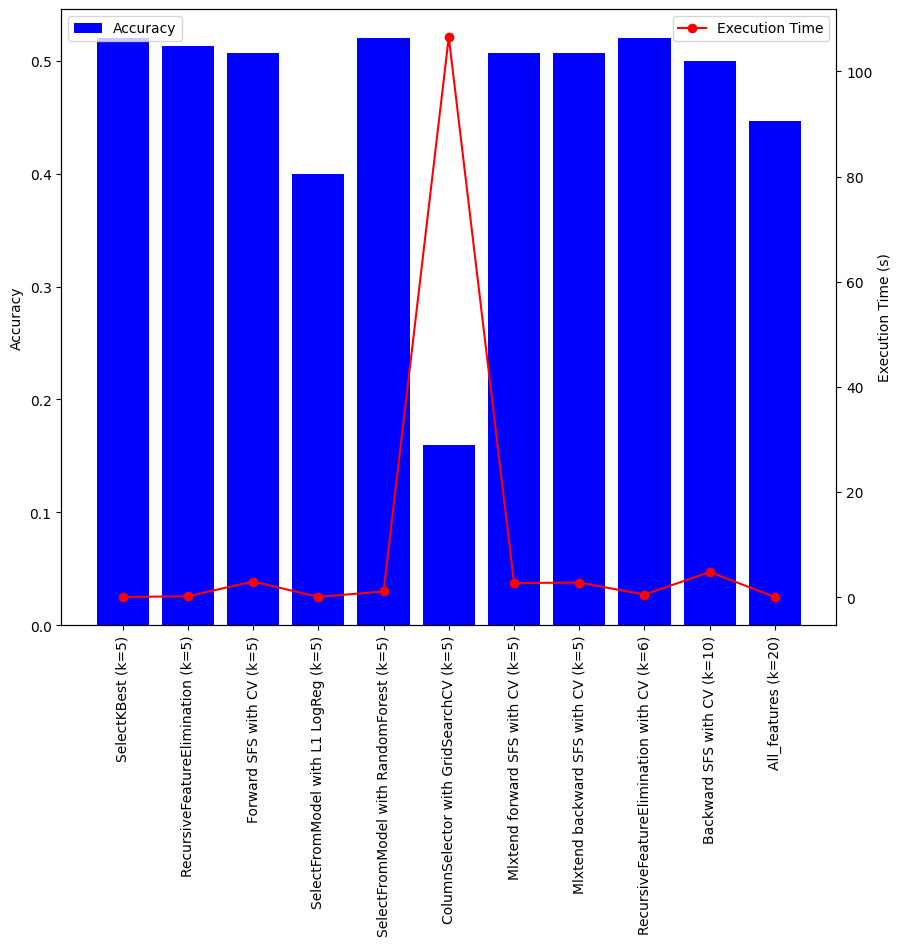

In [47]:
feature_selection_methods_gen, accuracies_gen, execution_times_gen = plot_method_comparisons(imp_features_dict_gen, X_train, y_train, X_test, y_test,
                                                                                 model=lambda: LogisticRegression())

In [48]:
output_best_candidates(feature_selection_methods_gen, accuracies_gen, execution_times_gen)

Feature selection method with the best accuracy: SelectKBest (k=5)
Accuracy value: 0.52

Feature selection method with the best time: SelectKBest (k=5)
Time value: 0.002976655960083008


<font size="5">**Conclusions:**</font> As we can see, SelectKBest with k=5 selected features provides both best accuracy and execution speed (SelectFromModel with RandomForest (k=5)) and RecursiveFeatureElimination with CV (k=6) provide the same accuracy). Additionally, most of the methods provide much better results, than simply using all the features, which which is expected since our generated data had many redundant or noise columns. If we look at the SelectFromModel results, we can see that using RandomForest as an estimator provides much better accuracy than L1 LogisticRegression (their speed is the same).

#### Generated data with n_features > n_samples

In [50]:
imp_features_dict_gen_insuff = {ALL_FEATURES_STR + f" (k={X_gen_insuff.shape[1]})": [np.arange(X_gen_insuff.shape[1]), 0]}
X_train, X_test, y_train, y_test = train_test_split(X_gen_insuff,
                                                    y_gen_insuff,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y_gen_insuff)

estimator_gen_insuff = LogisticRegression()

#### Univariate feature selection

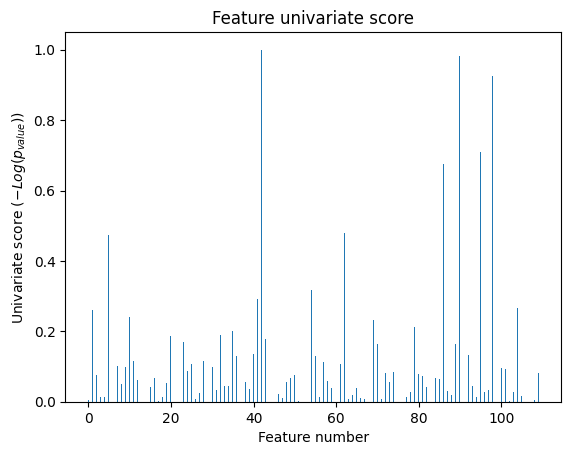

In [51]:
selector, scores, tic, toc = performSelectKBest(X_train, y_train)

In [52]:
selected_features = selector.get_support(indices=True)
for idx in selected_features:
    print(f"Selected feature index: {idx}, score: {scores[idx]:.2f}")

delta = toc - tic
print(f"Done in {delta:.3f}s")

imp_features_dict_gen_insuff.update({"SelectKBest (k=5)": [selected_features, delta]})

Selected feature index: 42, score: 1.00
Selected feature index: 86, score: 0.68
Selected feature index: 90, score: 0.98
Selected feature index: 95, score: 0.71
Selected feature index: 98, score: 0.92
Done in 0.002s


#### Recursive feature elimination (RFE)

In [53]:
selector = RFE(estimator_gen_insuff, n_features_to_select=5, step=1)
find_and_print_features(selector, X_train, y_train, imp_features_dict_gen_insuff, None,
                            "RecursiveFeatureElimination", lambda x: 5)# because there are 5 selected features

Optimal feature quantity: 5
Selected feature index: 20
Selected feature index: 29
Selected feature index: 42
Selected feature index: 90
Selected feature index: 98
Done in 0.576s


#### Recursive feature elimination with Cross Validation (RFECV)

In [54]:
min_features_to_select = 1
rfecv = RFECV(
    estimator=estimator_gen_insuff,
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

find_and_print_features(rfecv, X_train, y_train, imp_features_dict_gen_insuff, None,
                            "RecursiveFeatureElimination with CV", lambda x: x.n_features_)

Optimal feature quantity: 71
Selected feature index: 1
Selected feature index: 5
Selected feature index: 6
Selected feature index: 7
Selected feature index: 9
Selected feature index: 10
Selected feature index: 11
Selected feature index: 12
Selected feature index: 13
Selected feature index: 14
Selected feature index: 15
Selected feature index: 16
Selected feature index: 19
Selected feature index: 20
Selected feature index: 21
Selected feature index: 23
Selected feature index: 24
Selected feature index: 25
Selected feature index: 27
Selected feature index: 28
Selected feature index: 29
Selected feature index: 30
Selected feature index: 32
Selected feature index: 35
Selected feature index: 36
Selected feature index: 38
Selected feature index: 40
Selected feature index: 41
Selected feature index: 42
Selected feature index: 43
Selected feature index: 44
Selected feature index: 45
Selected feature index: 46
Selected feature index: 48
Selected feature index: 49
Selected feature index: 50
Sele

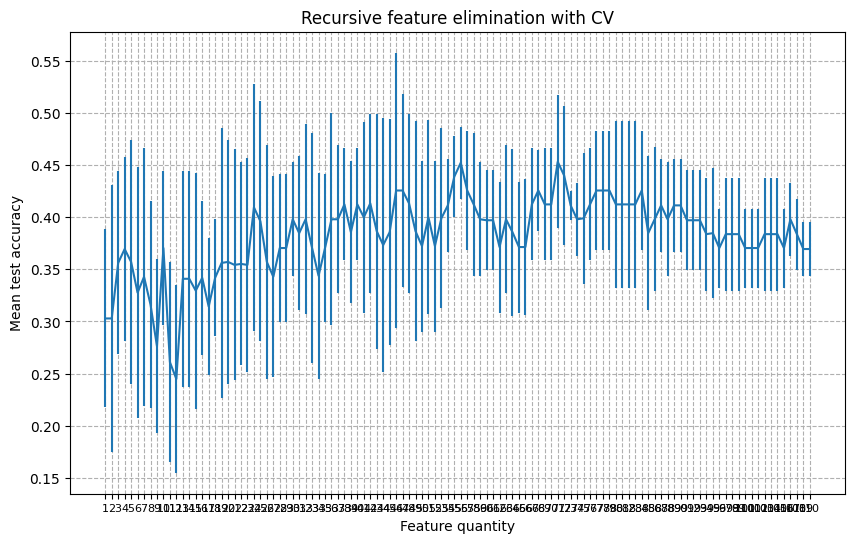

In [55]:
rfecv_plot(rfecv)

#### Sequential Feature Forward Selection

In [56]:
sf_selector = SFS(
    estimator=estimator_gen_insuff,
    scoring="accuracy",
    tol=0.0275,
    n_jobs=-1,
) # default 5 fold cross-validation

find_and_print_features(sf_selector, X_train, y_train, imp_features_dict_gen_insuff, None,
                            "Forward SFS with CV", lambda x: x.n_features_to_select_)

Optimal feature quantity: 6
Selected feature index: 36
Selected feature index: 42
Selected feature index: 44
Selected feature index: 86
Selected feature index: 90
Selected feature index: 104
Done in 20.194s


#### Sequential Feature Backward Selection

In [57]:
sf_selector = SFS(
    estimator=estimator_gen_insuff,
    direction="backward",
    scoring="accuracy",
    n_jobs=-1,
) # default 5 fold cross-validation
# tolerance is not set, since no value provides
# amount of features less than 77

find_and_print_features(sf_selector, X_train, y_train, imp_features_dict_gen_insuff, None,
                            "Backward SFS with CV", lambda x: x.n_features_to_select_)

Optimal feature quantity: 55
Selected feature index: 1
Selected feature index: 9
Selected feature index: 10
Selected feature index: 12
Selected feature index: 13
Selected feature index: 15
Selected feature index: 16
Selected feature index: 19
Selected feature index: 20
Selected feature index: 24
Selected feature index: 25
Selected feature index: 28
Selected feature index: 29
Selected feature index: 32
Selected feature index: 35
Selected feature index: 37
Selected feature index: 40
Selected feature index: 41
Selected feature index: 42
Selected feature index: 43
Selected feature index: 45
Selected feature index: 50
Selected feature index: 53
Selected feature index: 54
Selected feature index: 57
Selected feature index: 58
Selected feature index: 62
Selected feature index: 65
Selected feature index: 69
Selected feature index: 70
Selected feature index: 73
Selected feature index: 74
Selected feature index: 75
Selected feature index: 79
Selected feature index: 80
Selected feature index: 81
S

#### SelectFromModel with L1 Logistic Regression

In [58]:
# Create a Logistic Regression model with L1 regularization
logreg = LogisticRegression(penalty='l1', solver='liblinear')
# Create a SelectFromModel object
selector = SelectFromModel(logreg, threshold=1.55)

find_and_print_features(selector, X_train, y_train, imp_features_dict_gen_insuff, None,
                            "SelectFromModel with L1 LogReg", lambda x: x.transform(X_train).shape[1])

Optimal feature quantity: 5
Selected feature index: 20
Selected feature index: 32
Selected feature index: 42
Selected feature index: 90
Selected feature index: 98
Done in 0.007s


#### SelectFromModel with Random Forest Classifier

In [59]:
forest = RFC(n_estimators=500, random_state=RANDOM_STATE)
# Create a SelectFromModel object
selector = SelectFromModel(forest, threshold=0.021)

find_and_print_features(selector, X_train, y_train, imp_features_dict_gen_insuff, None,
                            "SelectFromModel with RandomForest", lambda x: x.transform(X_train).shape[1])

Optimal feature quantity: 5
Selected feature index: 42
Selected feature index: 86
Selected feature index: 90
Selected feature index: 95
Selected feature index: 98
Done in 0.711s


#### Grid Search Cross Validation for feature ranking using ColumnSelector

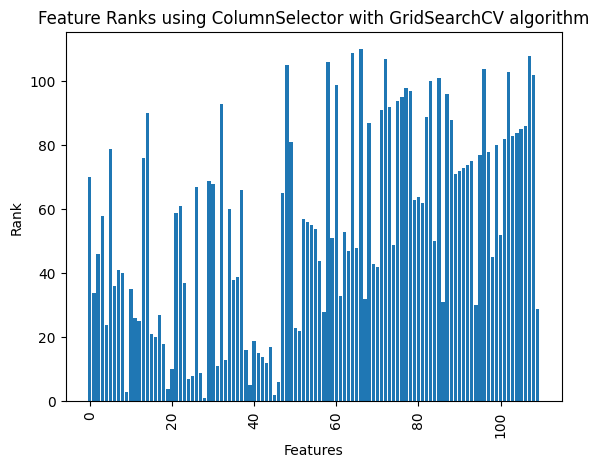

Feature: 28, Rank: 1
Feature: 45, Rank: 2
Feature: 9, Rank: 3
Feature: 19, Rank: 4
Feature: 39, Rank: 5
Done in 205.933s


In [60]:
column_selector_gs_cv(X_train, y_train, imp_features_dict_gen_insuff, np.arange(X_train.shape[1]), num_splits=4)

#### Mlxtend Sequential Feature Forward Selection

In [61]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    mlx_sfs = mlx_SFS(
        estimator_gen_insuff, 
        k_features="parsimonious", 
        forward=True, 
        floating=False, 
        verbose=2,
        scoring='accuracy',
        cv=5,
        n_jobs=-1
        )
    
    find_and_print_features(mlx_sfs, X_train, y_train, imp_features_dict_gen_insuff, None,
                            "Mlxtend forward SFS with CV",
                            optimal_feat_quant_func=lambda x: len(x.k_feature_idx_),
                            select_features_func=lambda x: x.k_feature_idx_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.4s finished

[2024-03-09 13:20:27] Features: 1/110 -- score: 0.2761904761904762[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.5s finished

[2024-03-09 13:20:28] Features: 2/110 -- score: 0.4095238095238095[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.6s finished

[2024-03-09 13:20:28] Features: 3/110 -- score: 0.4790476190476191[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 107 ou

Optimal feature quantity: 30
Selected feature index: 4
Selected feature index: 5
Selected feature index: 6
Selected feature index: 7
Selected feature index: 14
Selected feature index: 32
Selected feature index: 36
Selected feature index: 38
Selected feature index: 40
Selected feature index: 41
Selected feature index: 42
Selected feature index: 44
Selected feature index: 45
Selected feature index: 48
Selected feature index: 54
Selected feature index: 56
Selected feature index: 62
Selected feature index: 66
Selected feature index: 82
Selected feature index: 84
Selected feature index: 85
Selected feature index: 86
Selected feature index: 89
Selected feature index: 90
Selected feature index: 93
Selected feature index: 94
Selected feature index: 98
Selected feature index: 104
Selected feature index: 105
Selected feature index: 109
Done in 65.105s



[2024-03-09 13:21:32] Features: 108/110 -- score: 0.3971428571428572[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2024-03-09 13:21:32] Features: 109/110 -- score: 0.3838095238095238[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[2024-03-09 13:21:32] Features: 110/110 -- score: 0.36952380952380953

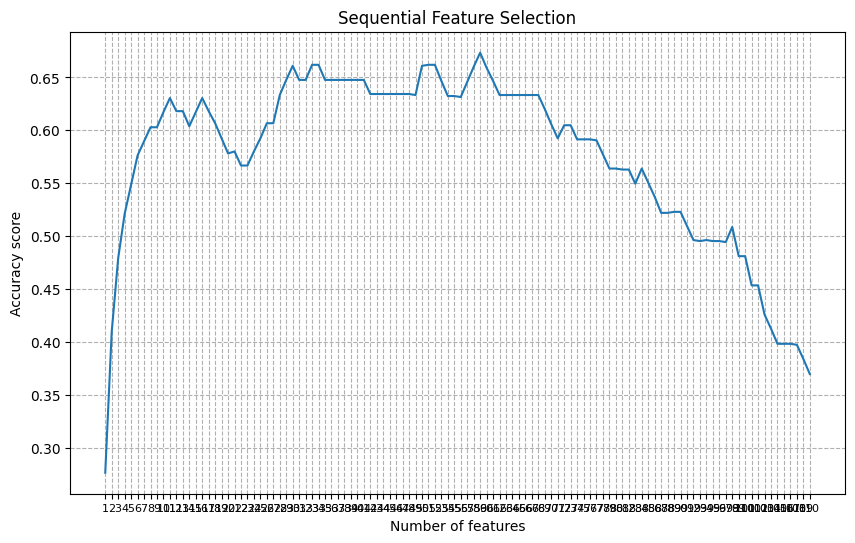

In [62]:
sfs_plot(mlx_sfs)

#### Mlxtend Sequential Feature Backward Selection

In [63]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    mlx_sfs = mlx_SFS(
        estimator_gen_insuff, 
        k_features="parsimonious", 
        forward=False, #backwards selection
        floating=False, 
        verbose=2,
        scoring='accuracy',
        cv=5,
        n_jobs=-1
        )
    
    find_and_print_features(mlx_sfs, X_train, y_train, imp_features_dict_gen_insuff, None,
                            "Mlxtend backward SFS with CV",
                            optimal_feat_quant_func=lambda x: len(x.k_feature_idx_),
                            select_features_func=lambda x: x.k_feature_idx_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.8s finished

[2024-03-09 13:21:33] Features: 109/1 -- score: 0.3980952380952381[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    0.9s finished

[2024-03-09 13:21:34] Features: 108/1 -- score: 0.4114285714285715[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.9s finished

[2024-03-09 13:21:35] Features: 107/1 -- score: 0.41238095238095235[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jo

Optimal feature quantity: 26
Selected feature index: 5
Selected feature index: 7
Selected feature index: 11
Selected feature index: 19
Selected feature index: 20
Selected feature index: 23
Selected feature index: 28
Selected feature index: 32
Selected feature index: 35
Selected feature index: 39
Selected feature index: 40
Selected feature index: 42
Selected feature index: 43
Selected feature index: 54
Selected feature index: 65
Selected feature index: 70
Selected feature index: 78
Selected feature index: 79
Selected feature index: 80
Selected feature index: 89
Selected feature index: 90
Selected feature index: 91
Selected feature index: 95
Selected feature index: 98
Selected feature index: 106
Selected feature index: 109
Done in 721.196s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2024-03-09 13:33:33] Features: 4/1 -- score: 0.5066666666666666[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2024-03-09 13:33:33] Features: 3/1 -- score: 0.4504761904761905[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2024-03-09 13:33:33] Features: 2/1 -- score: 0.4095238095238095[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2024-03-09 13:33:33] Features: 1/1 -- score: 0.2761904761904762

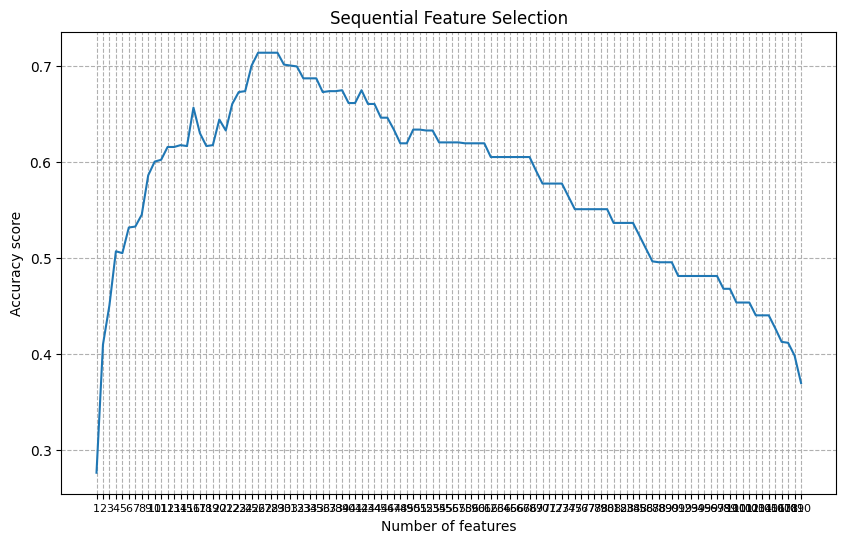

In [64]:
sfs_plot(mlx_sfs)

### Comparing all methods results for the Generated Dataset with insufficient amount of records

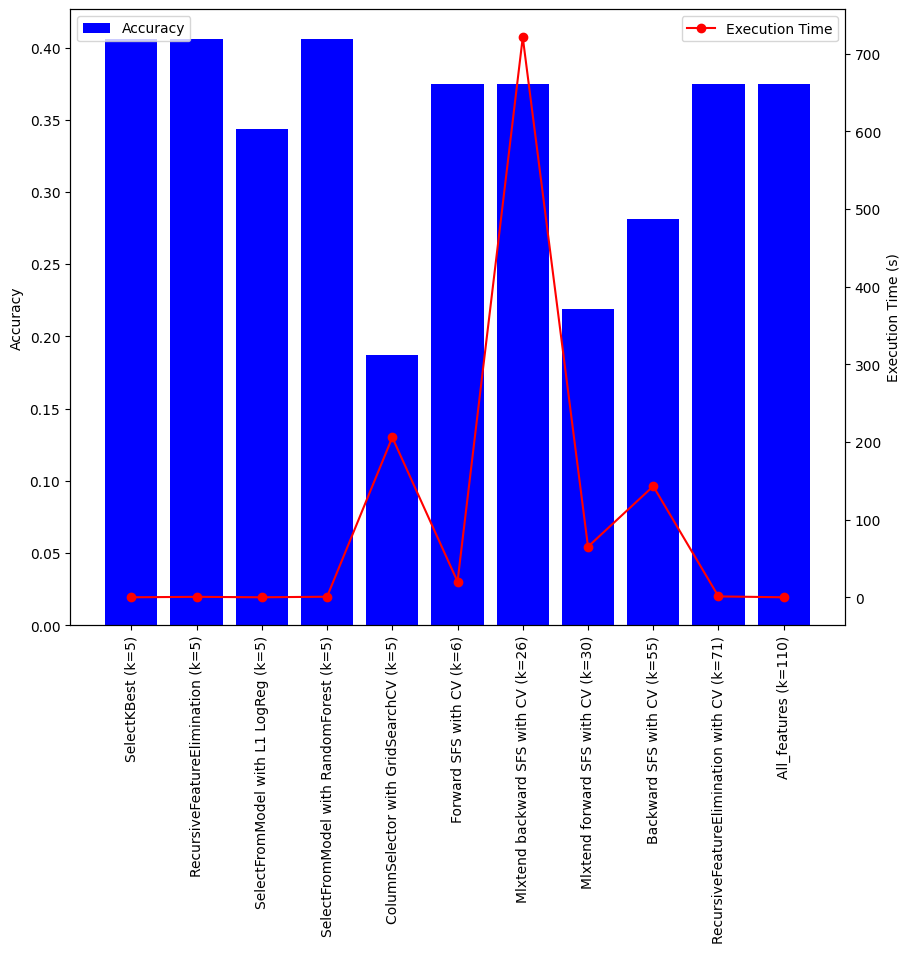

In [65]:
feature_selection_methods_gen_insuff, accuracies_gen_insuff, execution_times_gen_insuff = \
    plot_method_comparisons(imp_features_dict_gen_insuff, X_train, y_train, X_test, y_test, model=lambda: LogisticRegression())

In [66]:
output_best_candidates(feature_selection_methods_gen_insuff, accuracies_gen_insuff, execution_times_gen_insuff)

Feature selection method with the best accuracy: SelectKBest (k=5)
Accuracy value: 0.40625

Feature selection method with the best time: SelectKBest (k=5)
Time value: 0.0020003318786621094


<font size="5">**Conclusions:**</font> As we can see, the accuracy of the model drops significantly (but it is still better than random classifier with the accuracy of 12.5%), which is expected, since we have more features than samples. In this case, the time required for methods execution is much larger, and more methods provide worse accuracy than just simply taking all features, since it is harder for them to find important features amoung all of the features. We get the best results with 'SelectKBest (k=5)', 'RecursiveFeatureElimination (k=5)' and 'SelectFromModel with RandomForest (k=5)'.